# Large stretch
[![Google Collab Book](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/meyer-nils/torch-fem/blob/main/examples/basic/solid/large_stretch.ipynb)

We compare different material models for uni-axial strain with a large stretch of up to five times its original length.

In [1]:
import matplotlib.pyplot as plt
import torch


from torchfem import Planar
from torchfem.mesh import rect_quad
from torchfem.materials import (
    IsotropicElasticityPlaneStress,
    IsotropicHenckyPlaneStress,
)

torch.set_default_dtype(torch.float64)

# Material
E = 1000.0
nu = 0.3
lbd = E * nu / ((1.0 + nu) * (1.0 - 2.0 * nu))
mu = E / (2.0 * (1.0 + nu))
K = lbd + 2.0 / 3.0 * mu
C10 = mu / 2
D1 = 2 / K


# Generate cube
nodes, elements = rect_quad(5, 5)

# Boundary sets
left = nodes[:, 0] == 0.0
right = nodes[:, 0] == 1.0
center1 = nodes[:, 1] == 0.5

# Load
U = 4.0
N = 21
displacements = torch.zeros_like(nodes)
displacements[right, 0] = U
increments = torch.linspace(0.0, 1.0, N)

# Boundary conditions
constraints = torch.zeros_like(nodes, dtype=bool)
constraints[left, 0] = True
constraints[right, 0] = True
constraints[center1, 1] = True

# Analytical stretch solution
λ = torch.linspace(1.0, 1.0 + U, N)

## Linear elasticity with small strains

In [2]:
# Reference solution
σ1_ref = torch.linspace(0.0, E * U, N)

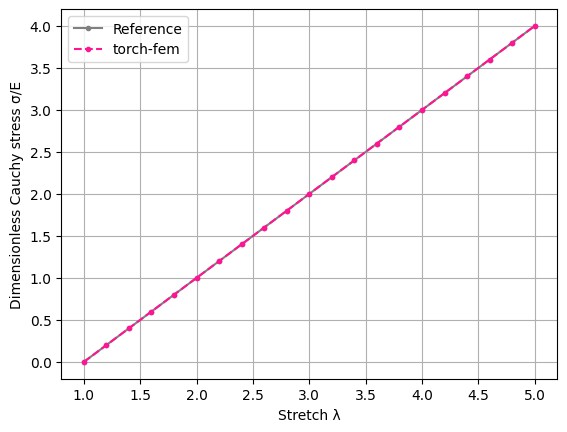

In [3]:
# Create model
material = IsotropicElasticityPlaneStress(E=E, nu=nu)
rect = Planar(nodes, elements, material)
rect.constraints = constraints
rect.displacements = displacements

# Solve
u1, f1, σ1, F1, α1 = rect.solve(increments=increments, return_intermediate=True)

# Plot
plt.plot(λ, σ1_ref / E, ".-", color="gray", label="Reference")
plt.plot(λ, σ1[..., 0, 0].mean(dim=1) / E, ".--", color="deeppink", label="torch-fem")
plt.xlabel("Stretch λ")
plt.ylabel("Dimensionless Cauchy stress σ/E")
plt.grid()
plt.legend()
plt.show()

## Hencky material

In [4]:
# Reference solution
σ2_ref = torch.log(λ) * E

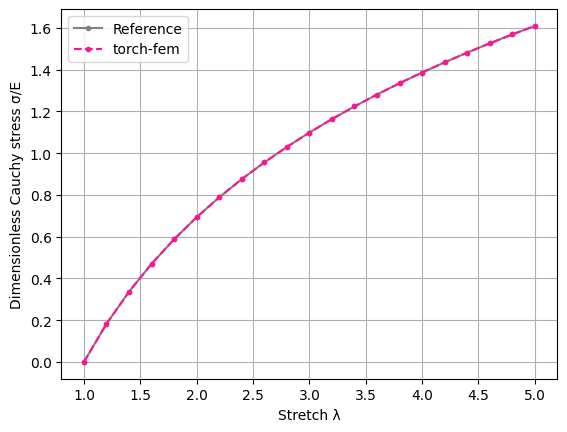

In [5]:
# Create model
material = IsotropicHenckyPlaneStress(E=E, nu=nu)
box = Planar(nodes, elements, material)
box.constraints = constraints
box.displacements = displacements

# Solve
u2, f2, σ2, F2, α2 = box.solve(
    increments=increments, return_intermediate=True, nlgeom=True
)

plt.plot(λ, σ2_ref / E, ".-", color="gray", label="Reference")
plt.plot(λ, σ2[..., 0, 0].mean(dim=1) / E, ".--", color="deeppink", label="torch-fem")
plt.xlabel("Stretch λ")
plt.ylabel("Dimensionless Cauchy stress σ/E")
plt.grid()
plt.legend()
plt.show()